In [5]:
import numpy as np 
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv2
from tqdm import tqdm
from sklearn.utils import shuffle 
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from zipfile import ZipFile

In [7]:
# Unzip files
def unzipfile(zipfile):
  with ZipFile(zipfile, 'r') as zipObj:
    zipObj.extractall()

In [8]:
# unzipping the zip file
unzipfile('archive.zip')

In [9]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [10]:
from tqdm import tqdm #loading the data
def load_data():
    datasets = ['archive/seg_train/seg_train/seg_train', 'archive/seg_test/seg_test/seg_test']
    output = []

    for dataset in datasets:       
        images1 = []
        labels1 = []
        
        print("Loading {}".format(dataset))

        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(os.path.join(dataset, folder),file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                images1.append(image)
                labels1.append(label)
                
        images1 = np.array(images1, dtype = 'float32')
        labels1 = np.array(labels1, dtype = 'int32')           
        output.append((images1, labels1))
    return output

(train_images1, train_labels1), (test_images1, test_labels1) = load_data()

Loading archive/seg_train/seg_train/seg_train


100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:06<00:00, 388.47it/s]


Loading archive/seg_test/seg_test/seg_test


100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:01<00:00, 318.24it/s]


In [11]:
from sklearn.utils import shuffle 
train_images1, train_labels1 = shuffle(train_images1, train_labels1, random_state=25)

s_train = train_labels1.shape[0]
s_test = test_labels1.shape[0]

print ("Number of train examples: {}".format(s_train))
print ("Number of test examples: {}".format(s_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of train examples: 14034
Number of test examples: 3000
Each image is of size: (150, 150)


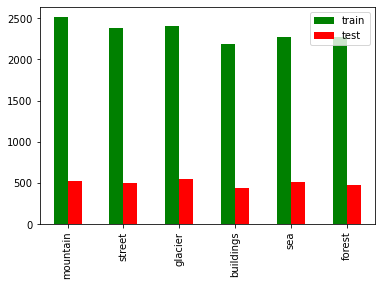

In [12]:
import pandas as pd
_, train_counts = np.unique(train_labels1, return_counts=True)
_, test_counts = np.unique(test_labels1, return_counts=True)
pd.DataFrame({'train': train_counts,'test': test_counts}, index=class_names).plot.bar(color=['green', 'red'])
plt.show()


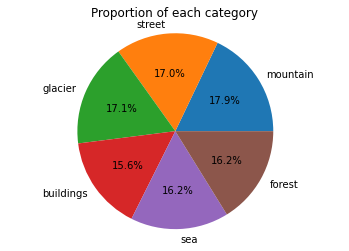

In [15]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each category')
plt.show()

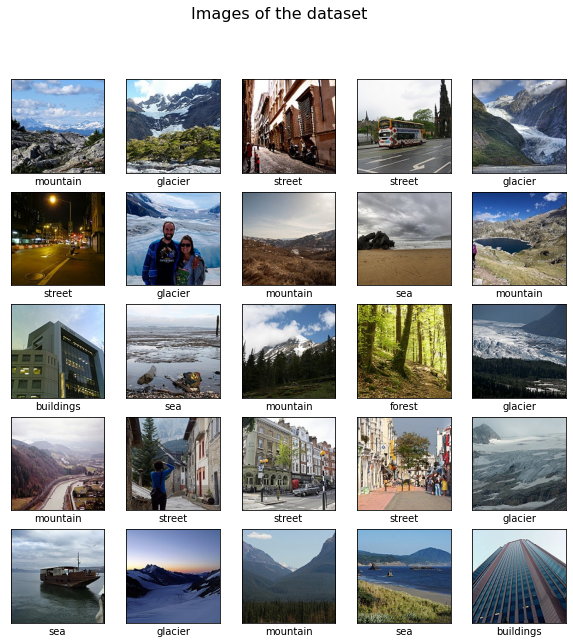

In [13]:
#scaling the data
train_images1 = train_images1 / 255.0 
test_images1 = test_images1 / 255.0

#data visualization


def display_examples(class_names, images1, labels1):
   
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images1[i])
        plt.xlabel(class_names[labels1[i]])
    plt.show()

display_examples(class_names, train_images1, train_labels1)


In [14]:
#Building the model using keras

import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['acc'])

In [16]:
#fitting the model
history = model.fit(train_images1, train_labels1, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 183s 2s/step - loss: 1.2372 - acc: 0.5621 - val_loss: 0.8918 - val_acc: 0.6551
Epoch 2/10
88/88 [==============================] - 174s 2s/step - loss: 0.7677 - acc: 0.7193 - val_loss: 0.6994 - val_acc: 0.7524
Epoch 3/10
88/88 [==============================] - 177s 2s/step - loss: 0.6052 - acc: 0.7868 - val_loss: 0.6962 - val_acc: 0.7453
Epoch 4/10
88/88 [==============================] - 177s 2s/step - loss: 0.4711 - acc: 0.8385 - val_loss: 0.6556 - val_acc: 0.7688
Epoch 5/10
88/88 [==============================] - 138s 2s/step - loss: 0.3495 - acc: 0.8864 - val_loss: 0.7083 - val_acc: 0.7563
Epoch 6/10
88/88 [==============================] - 126s 1s/step - loss: 0.2419 - acc: 0.9232 - val_loss: 0.7649 - val_acc: 0.7485
Epoch 7/10
88/88 [==============================] - 125s 1s/step - loss: 0.1808 - acc: 0.9434 - val_loss: 0.7625 - val_acc: 0.7652
Epoch 8/10
88/88 [==============================] - 118s 1s/step - loss: 0.1196 - a

In [17]:
#Plot the accuracy and the loss during the training of the nn.
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10,5))
    
    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

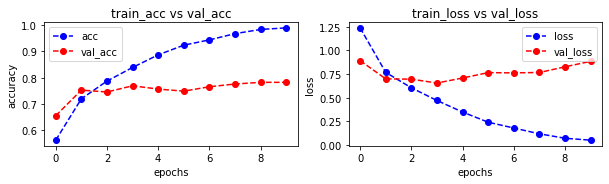

94/94 [==============================] - 6s 61ms/step


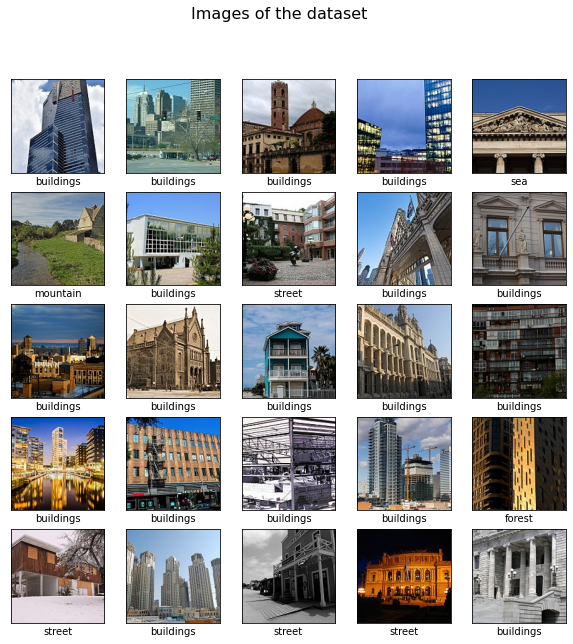

In [18]:
plot_accuracy_loss(history)

test_loss = model.evaluate(test_images1, test_labels1)

predictions = model.predict(test_images1)     # Vector of probabilities
pred_labels1 = np.argmax(predictions, axis = 1) # We take the highest probability

display_examples(class_names, test_images1, pred_labels1)

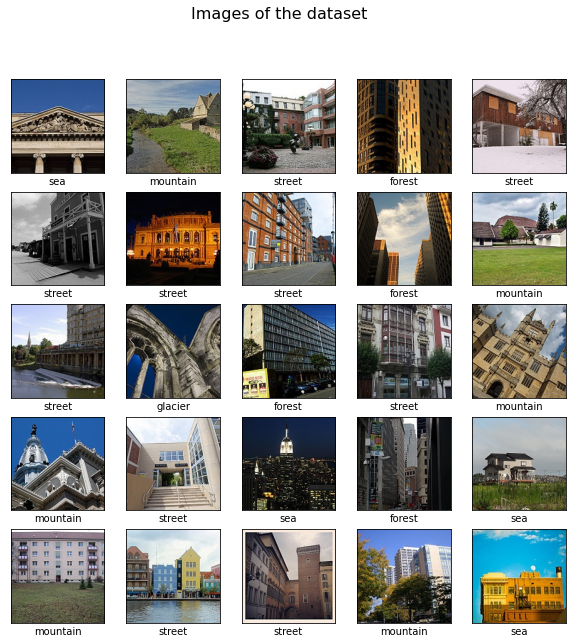

In [19]:
#error analysis
def print_mislabeled_images1(class_names, test_images1, test_labels1, pred_labels1):
  
    BOO = (test_labels1 == pred_labels1)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images1 = test_images1[mislabeled_indices]
    mislabeled_labels1 = pred_labels1[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images1, mislabeled_labels1)
print_mislabeled_images1(class_names, test_images1, test_labels1, pred_labels1)

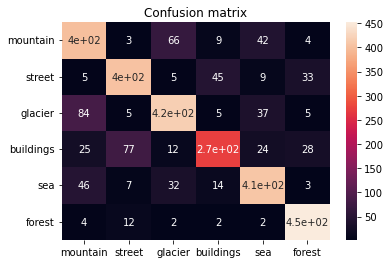

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
CM = confusion_matrix(test_labels1, pred_labels1)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [21]:
#second model  ImageNet
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

train_features = model.predict(train_images1)
test_features = model.predict(test_images1)
s_train, x, y, z = train_features.shape
s_test, x, y, z = test_features.shape
numFeatures = x * y * z

model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels1, batch_size=128, epochs=10, validation_split = 0.2)

94/94 [==============================] - 248s 3s/step
Epoch 1/10
88/88 [==============================] - 3s 19ms/step - loss: 0.5162 - accuracy: 0.8124 - val_loss: 0.3746 - val_accuracy: 0.8582
Epoch 2/10
88/88 [==============================] - 1s 13ms/step - loss: 0.3098 - accuracy: 0.8875 - val_loss: 0.3337 - val_accuracy: 0.8767
Epoch 3/10
88/88 [==============================] - 1s 14ms/step - loss: 0.2463 - accuracy: 0.9146 - val_loss: 0.3196 - val_accuracy: 0.8778
Epoch 4/10
88/88 [==============================] - 1s 14ms/step - loss: 0.2026 - accuracy: 0.9299 - val_loss: 0.3237 - val_accuracy: 0.8757
Epoch 5/10
88/88 [==============================] - 1s 14ms/step - loss: 0.1759 - accuracy: 0.9409 - val_loss: 0.3073 - val_accuracy: 0.8888
Epoch 6/10
88/88 [==============================] - 1s 13ms/step - loss: 0.1410 - accuracy: 0.9546 - val_loss: 0.3539 - val_accuracy: 0.8721
Epoch 7/10
88/88 [==============================] - 1s 14ms/step - loss: 0.1269 - accuracy: 0.9588 -

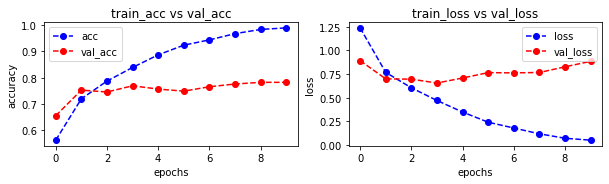

94/94 [==============================] - 0s 4ms/step - loss: 0.3674 - accuracy: 0.8763


In [22]:

plot_accuracy_loss(history)

test_loss = model2.evaluate(test_features, test_labels1)
